In [ ]:
# ⚠️ DISCLAIMER:
# The model compilation and training code is commented out (hashtagged) 
# because the model has already been trained and saved.
# Re-running the training process takes approximately 2–3 hours.
# To use the app, simply load the saved model: 'leafy_crop_disease_best_val_loss_v2.keras'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models

In [2]:
# Set your dataset path
dataset_path = 'Plant_Disease_Dataset'
dataset_path

'Plant_Disease_Dataset'

In [3]:
# Dictionary to hold class counts
class_counts = defaultdict(int)

# Loop through each subfolder (class)
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        # Count number of image files in each class
        num_images = len([
            fname for fname in os.listdir(class_folder)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts[class_name] = num_images
        
# Print results in sorted order
for classname, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{classname}: {count} images")

Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Tomato_Bacterial_spot: 2127 images
Tomato_Late_blight: 1909 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato_healthy: 1591 images
Pepper__bell___healthy: 1478 images
Tomato__Target_Spot: 1404 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Tomato_Early_blight: 1000 images
Pepper__bell___Bacterial_spot: 997 images
Tomato_Leaf_Mold: 952 images
Tomato__Tomato_mosaic_virus: 373 images
Potato___healthy: 152 images


In [4]:
dataset_path

'Plant_Disease_Dataset'

# Loading the images

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen

# Spliting the images in traning and validation datasets

In [6]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

train_generator

Found 16516 images belonging to 15 classes.


In [7]:
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

val_generator

Found 4122 images belonging to 15 classes.


# Computing Class Weights

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [9]:
# Get all training class indices
y_train = train_generator.classes
y_train

array([ 0,  0,  0, ..., 14, 14, 14])

In [10]:
# Get the unique class labels
class_labels = np.unique(y_train)
class_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [11]:
# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.379782790309106,
 1: 0.9307410538179769,
 2: 1.3763333333333334,
 3: 1.3763333333333334,
 4: 9.025136612021859,
 5: 0.6469251860556209,
 6: 1.3763333333333334,
 7: 0.7205933682373473,
 8: 1.4449693788276465,
 9: 0.7770406963067513,
 10: 0.8210787969177231,
 11: 0.9795966785290628,
 12: 0.4289313076223867,
 13: 3.6824972129319957,
 14: 0.8649384655669023}

In [12]:
# Get the mapping from class name to index
class_indices = train_generator.class_indices

# Reverse it: index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Print each class with its weight
for i, weight in class_weights_dict.items():
    print(f"{index_to_class[i]}: weight = {weight:.2f}")

Pepper__bell___Bacterial_spot: weight = 1.38
Pepper__bell___healthy: weight = 0.93
Potato___Early_blight: weight = 1.38
Potato___Late_blight: weight = 1.38
Potato___healthy: weight = 9.03
Tomato_Bacterial_spot: weight = 0.65
Tomato_Early_blight: weight = 1.38
Tomato_Late_blight: weight = 0.72
Tomato_Leaf_Mold: weight = 1.44
Tomato_Septoria_leaf_spot: weight = 0.78
Tomato_Spider_mites_Two_spotted_spider_mite: weight = 0.82
Tomato__Target_Spot: weight = 0.98
Tomato__Tomato_YellowLeaf__Curl_Virus: weight = 0.43
Tomato__Tomato_mosaic_virus: weight = 3.68
Tomato_healthy: weight = 0.86


# Visualize Image Batches Before Training

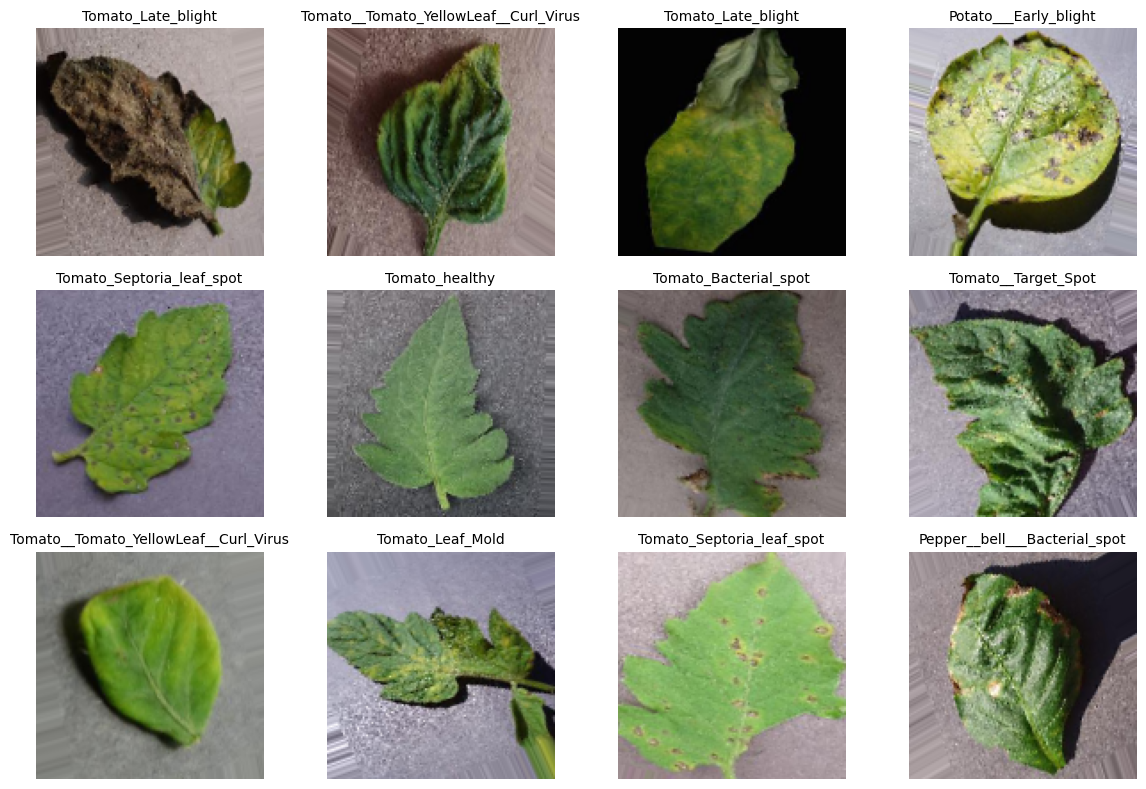

In [13]:
# Get a batch from train_generator
images, labels = next(train_generator)

# Plot the first 12 images
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    class_name = index_to_class[label_index]
    plt.title(class_name, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Trainig Convolution Neural Network(CNN) Model

In [14]:
from tensorflow.keras import layers, models

In [15]:
# Building the CNN Model

model_1 = models.Sequential([
    # Layer 1: Convolution + MaxPooling (Conv2D(32):Detects basic features like edges and corners)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    # Layer 2 (Conv2D(64): Detects more detailed shapes)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 3 (Conv2D(128): Detects complex textures, patterns)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 4 (Conv2D(256): Deep and rich filters)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten and Dense Layers (Flatten(): converts 2D feature into 1D, Dense(256): connect all the neurons togeather, Dropout(0.5): prevents overfitting)
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    # Output Layer (15 classes)
    layers.Dense(15, activation='softmax')
])

C:\Users\rites\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
# Compile the CNN Model

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Save the best model based on validation accuracy
# checkpoint_acc_v1 = ModelCheckpoint(
#     'leafy_crop_disease_best_val_accuracy_v1.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )

# # Save the best model based on validation loss
# checkpoint_loss_v1 = ModelCheckpoint(
#     'leafy_crop_disease_best_val_loss_v1.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# # Training with both checkpoints
# history_1 = model_1.fit(
#     train_generator,
#     epochs=15,
#     validation_data=val_generator,
#     class_weight=class_weights_dict,
#     callbacks=[checkpoint_acc_v1, checkpoint_loss_v1]
# )

In [18]:
#Load the saved model 

from tensorflow.keras.models import load_model

model_01 = load_model('leafy_crop_disease_best_val_loss_v1.keras')
model_01

<Sequential name=sequential, built=True>

# Evaluating on Validation Data

In [19]:
loss, accuracy = model_01.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

  1/129 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.8438 - loss: 0.4704

C:\Users\rites\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.9364 - loss: 0.1865
Validation Accuracy: 93.30%
Validation Loss: 0.1894


# Model Tuning

In [20]:
# # Imports
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Dataset Path
# dataset_path = 'Plant_Disease_Dataset'

# # Data Augmentation (Gentler version)
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     rotation_range=20,
#     zoom_range=0.2,
#     shear_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True
# )

# # Train and Validation Data Generators
# train_generator = datagen.flow_from_directory(
#     dataset_path,
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# val_generator = datagen.flow_from_directory(
#     dataset_path,
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

# # Class Weights
# y_train = train_generator.classes
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights_dict = dict(enumerate(class_weights))

# # Build CNN
# model_2 = models.Sequential([
#     layers.Input(shape=(128, 128, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(256, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(15, activation='softmax')
# ])

# # Compile the Model
# model_2.compile(
#     optimizer=Adam(learning_rate=0.0003),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Callbacks: EarlyStopping + LR Scheduler + Dual Model Checkpoints
# early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=2,
#     verbose=1,
#     min_lr=1e-6
# )

# # Save best model based on validation accuracy
# checkpoint_acc = ModelCheckpoint(
#     'leafy_crop_disease_best_val_accuracy_v2.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )

# # Save best model based on validation loss
# checkpoint_loss = ModelCheckpoint(
#     'leafy_crop_disease_best_val_loss_v2.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# # Train
# history_2 = model_2.fit(
#     train_generator,
#     epochs=60,
#     validation_data=val_generator,
#     class_weight=class_weights_dict,
#     callbacks=[early_stop, lr_scheduler, checkpoint_acc, checkpoint_loss]
# )

In [21]:
# Save class labels separately as a JSON file
import json

class_names = list(train_generator.class_indices.keys())  
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)


In [22]:
from tensorflow.keras.models import load_model

model_02 = load_model('leafy_crop_disease_best_val_loss_v2.keras')
model_02

<Sequential name=sequential_1, built=True>

In [23]:
loss, accuracy = model_02.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9829 - loss: 0.0627
Validation Accuracy: 98.13%
Validation Loss: 0.0636


# Testing Model on Real world single image

In [24]:
# Website: https://content.ces.ncsu.edu/tomato-late-blight

# Testing image from https://content.ces.ncsu.edu/tomato-late-blight#img_dialog_2782 {Used: image with white background} 

import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json

# Load your trained model
model_02 = load_model('leafy_crop_disease_best_val_loss_v2.keras')

# Load class labels (if you saved them)
with open('class_names.json', 'r') as f:
    class_names = json.load(f)

# Load and preprocess test image
img_path = 'test_leaf.jpg'  # Replace with test image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
predictions = model_02.predict(img_array)
predicted_index = np.argmax(predictions)
predicted_class = class_names[predicted_index]
confidence = predictions[0][predicted_index]

# Display result
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted Class: Tomato_Late_blight
Confidence: 79.13%
